### Packages and Libraries

In [ ]:
import os
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import numpy as np
import matplotlib.animation as animation
from skimage.transform import resize
from skimage import exposure
from tqdm import tqdm

import torch

import gc

### Paths

In [ ]:
os.chdir("/home/_shared/ARIEL/Faubai") 

folder_path = "/home/_shared/ARIEL/Faubai/"

file_path = os.path.join(folder_path, 'datalake', 'PRS_L1_STD_OFFL_20200421110225_20200421110229_0001.he5')
label_path = '/home/salyken/PRISMA/PRISMA_data/labels_csv/PRS_L1_STD_OFFL_20200421110225_20200421110229_0001_labels.csv'

Current Directory: /home/_shared/ARIEL/Faubai


### HYPSO-1 SRFs

SRF matrix shape: (117, 117)


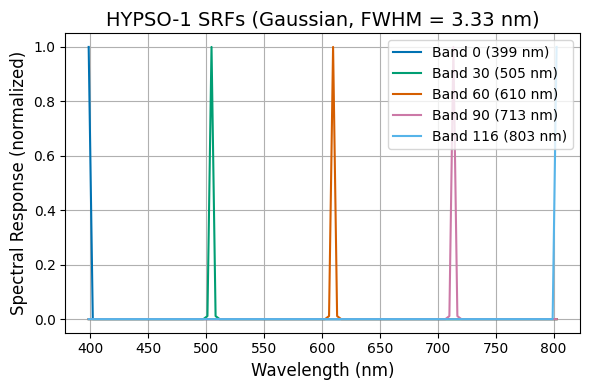

In [4]:
calib_dir = '/home/salyken/PRISMA/HYPSO_data/calibration_files'
bands_file = os.path.join(calib_dir, 'spectral_bands_HYPSO-1_v1.npz')


lambda_hypso = np.load(bands_file)['arr_0']  # shape (120,)

# ---- Set a fixed FWHM per band (e.g. 3.33 nm for all) ----
fwhm = np.full_like(lambda_hypso, 3.33)

# ---- Your provided function ----
def get_spectral_response_function(wavelengths, fwhm: np.array):
    sigma_nm = fwhm / (2 * np.sqrt(2 * np.log(2)))
    srf = []

    for i, center_lambda_nm in enumerate(wavelengths):
        start_lambda_nm = np.round(center_lambda_nm - (3 * sigma_nm[i]), 4)
        end_lambda_nm = np.round(center_lambda_nm + (3 * sigma_nm[i]), 4)

        # Define SRF support window
        lower_wl = [wl for wl in wavelengths if start_lambda_nm < wl < center_lambda_nm]
        upper_wl = [wl for wl in wavelengths if center_lambda_nm < wl < end_lambda_nm]

        # Make symmetric
        while len(lower_wl) > len(upper_wl): lower_wl.pop(0)
        while len(upper_wl) > len(lower_wl): upper_wl.pop(-1)

        srf_wl = lower_wl + [center_lambda_nm] + upper_wl
        good_idx = [(wl in srf_wl) for wl in wavelengths]

        # Gaussian response values
        gx = np.linspace(-3 * sigma_nm[i], 3 * sigma_nm[i], len(srf_wl)) if len(srf_wl) > 1 else [0]
        gaussian_srf = np.exp(-(gx / sigma_nm[i]) ** 2 / 2)

        srf_vector = np.zeros_like(wavelengths)
        srf_vector[good_idx] = gaussian_srf

        srf.append(srf_vector)

    return np.array(srf)  # shape: (120, 120)

# === Run and inspect ===
hypso_srf_matrix = get_spectral_response_function(lambda_hypso[3:], fwhm)
print("SRF matrix shape:", hypso_srf_matrix.shape)

# # Optional: Save
# np.savez_compressed('hypso_srf_gaussian.npz',
#     srf_matrix=hypso_srf_matrix,
#     wavelengths=lambda_hypso,
#     fwhm=fwhm
# )

lambda_hypso = lambda_hypso[3:]

# === Plot a few ===
plt.figure(figsize=(6, 4))

colors = ["#0072B2", "#009E73", "#D55E00", "#CC79A7", "#56B4E9"]  # colorblind-friendly

for c, idx in zip(colors, [0, 30, 60, 90, 116]):
    plt.plot(lambda_hypso, hypso_srf_matrix[idx], label=f"Band {idx} ({lambda_hypso[idx]:.0f} nm)", color=c)

plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Spectral Response (normalized)", fontsize=12)
plt.title("HYPSO-1 SRFs (Gaussian, FWHM = 3.33 nm)", fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


### PRISMA SRFs

PRISMA SRF shape: (47, 47)


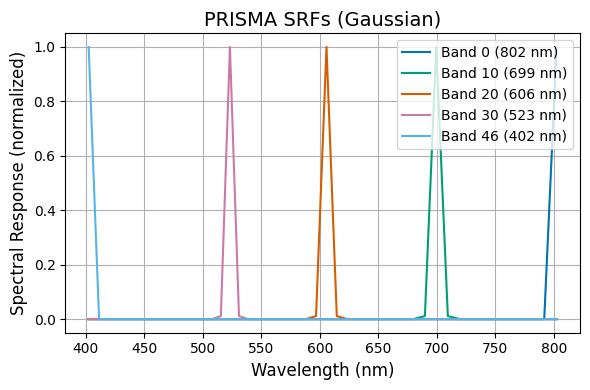

In [5]:
import h5py
import numpy as np

fn = "/home/_shared/ARIEL/Faubai/datalake/PRS_L1_STD_OFFL_20200421110225_20200421110229_0001.he5"

with h5py.File(fn, "r") as f:
    # 1) Pull in the per-pixel cw & fwhm matrices
    cw_mat   = f["KDP_AUX/Cw_Vnir_Matrix"][:]    
    fwhm_mat = f["KDP_AUX/Fwhm_Vnir_Matrix"][:]  # same shape
    vnir = f["HDFEOS/SWATHS/PRS_L1_HCO/Data Fields/VNIR_Cube"][:]

# 2) Collapse over the scan-line axis to get one vector per column
cw_mean   = cw_mat.mean(axis=0)    # shape (256,)
fwhm_mean = fwhm_mat.mean(axis=0)  # shape (256,)

# 3) Find the “real” band columns (where cw > 0)
mask = cw_mean > 0

lambda_prisma = cw_mean[mask]      # 
fwhm_prisma  = fwhm_mean[mask]    # same length

# Define HYPSO support range (based on lambda_hypso)
min_hypso_wl = lambda_hypso[0]
max_hypso_wl = lambda_hypso[-1]

# Mask PRISMA bands that fall within HYPSO support
clip_mask = (lambda_prisma >= min_hypso_wl) & (lambda_prisma <= max_hypso_wl)
lambda_prisma_clipped = lambda_prisma[clip_mask]
fwhm_prisma_clipped = fwhm_prisma[clip_mask]



def build_prisma_srf(wavelengths, fwhm):
    sigma_nm = fwhm / (2 * np.sqrt(2 * np.log(2)))
    srf = []

    for i, center_lambda_nm in enumerate(wavelengths):
        start_lambda_nm = np.round(center_lambda_nm - (3 * sigma_nm[i]), 4)
        end_lambda_nm   = np.round(center_lambda_nm + (3 * sigma_nm[i]), 4)

        # Define support window (symmetric)
        lower_wl = [wl for wl in wavelengths if start_lambda_nm < wl < center_lambda_nm]
        upper_wl = [wl for wl in wavelengths if center_lambda_nm < wl < end_lambda_nm]

        while len(lower_wl) > len(upper_wl): lower_wl.pop(0)
        while len(upper_wl) > len(lower_wl): upper_wl.pop(-1)

        srf_wl = lower_wl + [center_lambda_nm] + upper_wl
        good_idx = [(wl in srf_wl) for wl in wavelengths]

        gx = np.linspace(-3 * sigma_nm[i], 3 * sigma_nm[i], len(srf_wl)) if len(srf_wl) > 1 else [0]
        gaussian_srf = np.exp(-(gx / sigma_nm[i])**2 / 2)

        srf_vec = np.zeros_like(wavelengths)
        srf_vec[good_idx] = gaussian_srf
        srf.append(srf_vec)

    return np.array(srf)  # shape (num_bands, num_bands)

# Build and inspect
prisma_srf_matrix = build_prisma_srf(lambda_prisma_clipped, fwhm_prisma_clipped)
print("PRISMA SRF shape:", prisma_srf_matrix.shape)

# # Optional: Save
# np.savez_compressed('prisma_srf_gaussian.npz',
#     srf_matrix=prisma_srf_matrix,
#     wavelengths=lambda_prisma,
#     fwhm=fwhm_prisma
# )

# === 4. Plot a few sample SRFs ===
plt.figure(figsize=(6, 4))

colors = ["#0072B2", "#009E73", "#D55E00", "#CC79A7", "#56B4E9"]  # colorblind-friendly

for c, idx in zip(colors, [0, 10, 20, 30, 46]):
    plt.plot(lambda_prisma_clipped, prisma_srf_matrix[idx], label=f"Band {idx} ({lambda_prisma_clipped[idx]:.0f} nm)", color=c)

plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Spectral Response (normalized)", fontsize=12)
plt.title("PRISMA SRFs (Gaussian)", fontsize=14)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Projection Matrix

Final projection matrix shape: (47, 117)


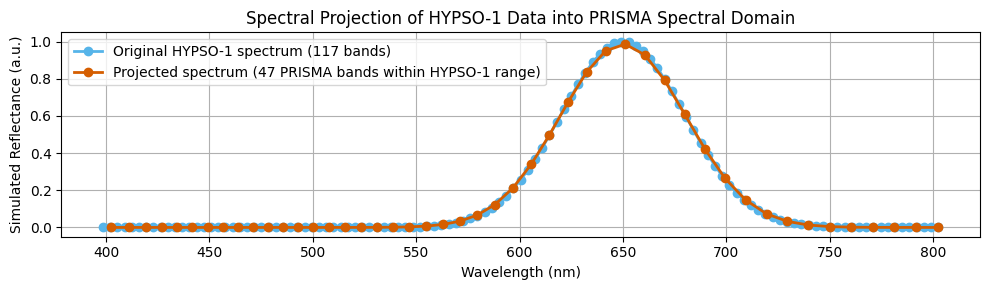

In [7]:

# --- Simulate example HYPSO spectrum ---
lambda_hypso = np.linspace(lambda_hypso[0,], lambda_hypso[116,], 117)
spectrum_hypso = np.exp(-(lambda_hypso - 650)**2 / (2 * 30**2))  # synthetic Gaussian spectrum

def gaussian_srf(center, wavelengths, fwhm):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return np.exp(-(wavelengths - center)**2 / (2 * sigma**2))

# Build W using variable FWHM per PRISMA band
W = np.array([
    gaussian_srf(lp, lambda_hypso, fwhm) 
    for lp, fwhm in zip(lambda_prisma_clipped, fwhm_prisma_clipped)
])
W = W / W.sum(axis=1, keepdims=True)  # normalize rows

print("Final projection matrix shape:", W.shape)  # should be (n_clipped_prisma, 117)


my_projection_matrix = torch.tensor(W, dtype=torch.float32)
np.save("/home/salyken/PRISMA/hypso_to_prisma_projection/hypso_to_prisma_projection.npy", W)


# --- Project HYPSO → PRISMA ---
spectrum_prisma = W @ spectrum_hypso

# --- Plot ---

plt.figure(figsize=(10, 3))
plt.plot(lambda_hypso, spectrum_hypso, label="Original HYPSO-1 spectrum (117 bands)", color="#56B4E9", lw=2,  marker='o')
plt.plot(lambda_prisma_clipped, spectrum_prisma, label="Projected spectrum (47 PRISMA bands within HYPSO-1 range)", color="#D55E00", lw=2, marker='o')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Simulated Reflectance (a.u.)")
plt.title("Spectral Projection of HYPSO-1 Data into PRISMA Spectral Domain")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Further Evaluation

In [9]:
# W shape is (63, 120)
coverage = W.sum(axis=1)  # Should be ≈ 1.0 for all rows
print("Coverage min/max:", coverage.min(), coverage.max())


Coverage min/max: 0.9999999999999998 1.0000000000000002


In [8]:
W.shape

(47, 117)

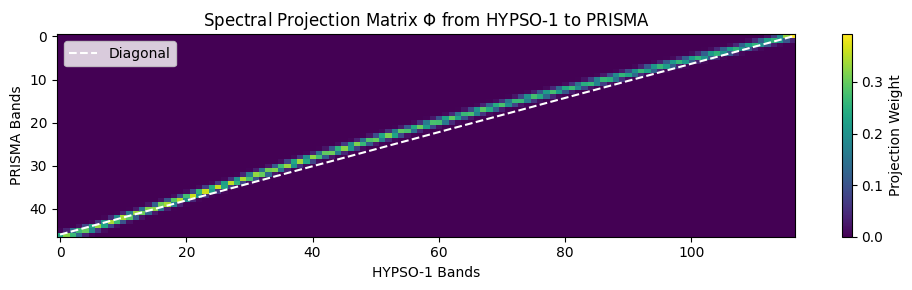

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 3))
plt.imshow(W, aspect='auto', cmap='viridis', origin='upper')
plt.colorbar(label='Projection Weight')
plt.plot([0, 116], [46, 0], color='white', linestyle='--', linewidth=1.5, label='Diagonal')
plt.xlabel("HYPSO-1 Bands")
plt.ylabel("PRISMA Bands")
plt.title(r"Spectral Projection Matrix $\Phi$ from HYPSO-1 to PRISMA")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
